In [1]:
# default_exp data_block
%load_ext autoreload
%autoreload 2

In [2]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# Data Block

> Primary handlers for interfacing the openai gym envs

In [3]:
# export
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
from fastai.callbacks import *
from fastrl.wrappers import *
from fastrl.basic_agents import *
from fastrl.metrics import *
from dataclasses import asdict,dataclass,field
from functools import partial
from fastprogress.fastprogress import IN_NOTEBOOK
from fastcore.utils import *
from fastcore.foundation import *
from torch.utils.data.dataset import IterableDataset
import torch.multiprocessing as mp
from functools import wraps
from queue import Empty
import textwrap
import logging
import gym

logging.basicConfig(format='[%(asctime)s] p%(process)s line:%(lineno)d %(levelname)s - %(message)s',
                    datefmt='%m-%d %H:%M:%S')
_logger=logging.getLogger(__name__)

In [4]:
# hide
_logger.setLevel('INFO')
import sys
from fastcore.test import *

## Dataset

`Dataset` instances are going to be a little different from the typically classification dataset that you might use in pytorch. Commonly, datasets have:
- A known size to iter through
- Maintain their state during the training sequence
- Randomly sample their dataset
- Have a common `x`/`y` or `input`/`target` data format

For our `ExperienceSourceDataset`, most of this is going to be different. 
- We can have multiple sources (envs)

You could think of a traditional dataset approach as being a mix of a `ExperienceSourceDataset` and a form of `ExperienceReplay`.

In [5]:
# export
@dataclass
class Experience(object):
    s:np.array
    sp:np.array
    a:np.array
    r:np.array
    d:np.array
    agent_s:np.array
        
    @property
    def x(self):return self.s.copy()
    @x.setter
    def x(self,v):self.s=v.copy()

add_docs(Experience,x='Should return the field for `xb` in the training loop. It must be copied on return or'
         ' else there will be strange multiple reference errors.'
         'This is intended to be fed directly into a model. The `self.s.copy()` is a single tensor to be directly fed into a regular nn.')

In [6]:
exp=Experience(s=np.random.randint(1,3,(5,5)),
               sp=np.random.randint(1,3,(5,5)),
               a=np.random.randint(1,3,(1,2)),
               r=np.random.randint(1,3,(1,20)),
               d=np.random.randint(0,1,(5,5)),
               agent_s=np.random.randint(0,6,(1,5)))
asdict(exp)

{'s': array([[1, 1, 1, 2, 2],
        [1, 1, 1, 1, 1],
        [1, 2, 2, 1, 2],
        [2, 1, 1, 2, 2],
        [1, 1, 1, 2, 2]]),
 'sp': array([[1, 1, 2, 1, 2],
        [2, 2, 2, 1, 1],
        [1, 1, 1, 1, 1],
        [2, 1, 1, 2, 2],
        [2, 1, 2, 2, 1]]),
 'a': array([[1, 1]]),
 'r': array([[2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2]]),
 'd': array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 'agent_s': array([[1, 3, 0, 2, 5]])}

## Datasets

We have a couple constraints on what the `ExperienceSourceDataset` is going to look like. For `__getitem__` it should return a tuple of 2 elements:

- `xb` which are the elements that are going to be directly fed into the model for getting actions.
- `yb` which are all of the elements provided by the environment that we can use for training.

Some semantics:
- `iter` means what is returned from `next(dataset)` for farthur what is returned from `[o for o in dataset]`.
- `step` means an individual step in the env. You can have multiple steps per `iter`.
- `batch_size` is the same thing as `step`.

In [7]:
# export
class ExperienceSourceCallback(LearnerCallback):
    def on_train_begin(self,*args,**kwargs):
        self.learn.data.train_dl.dataset.learn=self.learn
        if not self.learn.data.empty_val:
            self.learn.data.valid_dl.dataset.learn=self.learn

@dataclass
class ExperienceSourceDataset(IterableDataset):
    "Similar to fastai's `LabelList`, iters in-order samples from `1->len(envs)` `envs`."
    env:str
    n_envs:int=1
    learn:Optional[Learner]=None
    callback_fns:List[LearnerCallback]=field(default_factory=lambda:[ExperienceSourceCallback])
    # Behavior modification fields / param fields.
    skip_n_steps:int=1
    max_steps:Optional[int]=None
    pixels:bool=False
    # Env tracking fields
    per_env_d:np.array=None
    per_env_s:np.array=None
    per_env_steps:np.array=None
    per_env_rewards:np.array=None
    # Metric fields
    total_rewards:List=field(default_factory=list)
    total_steps:List=field(default_factory=list)
    # Private funcational fields.
    _env_idx:int=0
    _warned:bool=False
    _end_interation:bool=False
    _getitem_as_exp:bool=False
    
    
#     def __init__(self,env:str,n_envs=1,skip_n_steps=1,max_steps=None,pixels=False):
    def __post_init__(self):
        def make_env():
            env_o=gym.make(self.env)
            if self.pixels:env_o.reset()
            return env_o
            
        self.envs=[make_env() for _ in range(self.n_envs)]
        if self.pixels:self.envs=[PixelObservationWrapper(e) for e in self.envs]
            
        self.per_env_d:np.array=np.zeros((len(self.envs),))+1
        self.per_env_s:np.array=np.zeros((len(self.envs),*self.envs[0].observation_space.sample().shape))
        self.per_env_steps:np.array=np.zeros((len(self.envs)))
        self.per_env_rewards:np.array=np.zeros((len(self.envs)))
        
    def __len__(self): return ifnone(self.max_steps,self.envs[0].spec.max_episode_steps)
    @log_args
    def is_last_step(self,d,steps,idx,max_steps)->bool:return bool(d) or steps>=max_steps
    @log_args
    def at_start(self,idx,steps):return idx==0 and steps==0
    @log_args
    def skip_loop(self,steps,skip_steps,d):return steps%skip_steps!=0 and not d
    @log_args
    def cycle_env(self,idx,n_envs):self._env_idx=0 if idx==n_envs-1 else idx+1
    def stop_loop(self):
        self._end_interation=False
        raise StopIteration()
    @log_args
    def reset_envs(self,idx):
        for i,e in enumerate(self.envs):self.per_env_s[i]=e.reset() # TODO: There is the possiblity this will equal None (and crash)?
        self.per_env_steps=np.zeros((len(self.envs)),dtype=int)
        self.per_env_rewards=np.zeros((len(self.envs)))
    @log_args
    def pick_action(self,idx):
        if self.learn is None:
            if not self._warned:_logger.warning('`self.learn` is None. will use random actions instead.')
            self._warned=True
            return self.envs[0].action_space.sample(),np.zeros((1,1))
        return self.learn.predict(self.per_env_s[idx])
    
    def pop_total_rewards(self):
        total_rewards=self.total_rewards
        if total_rewards:self.total_rewards,self.total_steps=[],[]
        return total_rewards

    def pop_reward_steps(self):
        total_rewards,total_steps=self.total_rewards,self.total_steps
        res=list(zip(total_rewards,total_steps))
        if res:self.total_rewards,self.total_steps=[],[]
        return res
    
    def __iter__(self):
        while True:
            try:
                o=self.__getitem__(None)
                yield o
            except StopIteration:
                return
    
    @log_args
    def __getitem__(self,_):
        idx=self._env_idx  # This is the current env that we are running on
        if self._end_interation:self.stop_loop()
        if self.at_start(idx,self.per_env_steps[idx]):self.reset_envs(idx)
        
        while True:
            a,agent_s=self.pick_action(idx)
            sp,r,d,_=self.envs[idx].step(a)
            
            exp=Experience(self.per_env_s[idx],sp,a,r,d,agent_s=ifnone(agent_s,[]))
            
            self.per_env_rewards[idx]+=r
            self.per_env_s[idx]=sp
            self.per_env_steps[idx]+=1
            self.per_env_d[idx]=d
            
            if self.skip_loop(self.per_env_steps[idx],self.skip_n_steps,d):continue
            
            if self.is_last_step(self.per_env_d[idx],self.per_env_steps[idx],idx,len(self)):
                self.total_rewards.append(self.per_env_rewards[idx])
                self.total_steps.append(self.per_env_steps[idx])
                self.per_env_steps[idx]=0
                
                self.cycle_env(idx,len(self.envs))
                self._end_interation=True
                
            if self._getitem_as_exp:return exp
            return exp.x,asdict(exp) # Must copy or else torch keeps only last tensor

add_docs(ExperienceSourceDataset,
         __init__='Provides an easy interface to iterate through an env or list of envs.\n Some importants notes:\n'
                  'an iteration through a loop. This is the maximum steps, and may be less due to the environment ending early.\n'
                  '- `skip_n_steps` are the number of steps to skip in the returned elements. This can be seen as frame skipping.',
        pick_action='Returns the action and learner\'s `self.learn.model`\'s state as determined by the learner for a state `self.s`'  
                    'belonging to env `idx`. If the `self.learn` is None, a random action using the `action_space` from `self.envs[0]` is used.\n\n'
                    'For the sake of clarity, the return type is Tuple[Tensor,Tensor] which can be understood as [a,agent_s] or [action, agent state].\n\n'
                    'While the returned action like `1`,`2` if discrete and `[0.2,0.5,0.2,0.1]` is a continuous action output, the agent state\n'
                    'is simply the raw values are were used to get the action. This information can be useful where for example we have an agent playing\n'
                    'the cartpole game. The action can either be `0` or `1`. This is considered the "action".\n'
                    'The agent state is the result of `self.learn.model(self.s)`. This is the raw `nn.Module` output and in the cartpole env case, is likely a\n'
                    'tensor of `Tensor([0.35,0.75])`, which for a discrete agent would an action of `1`. (we do an argmax, thus the action is which ever \n'
                    'neuron has the highest expected reward. This can be used to determine how confident the agent was when taking an action.',
        is_last_step='An env has reached it\'s last step when it is either `d` is true or `steps` is more than or equal to `self.max_steps-1`. '
                     'The reason this method has so many parameters is due to the use of `log_args` decorator. Having these all these parameters passed on makes '
                     'debugging much easier.',
        cycle_env='Increments the private `self._step` field to cyucle through the envs. Requires passing in parameters for easy debugging using `log_args`.',
        stop_loop='Raises the `StopIteration` exception and resets the `self._end_interation=False`. Used when the current env is done.',
        reset_envs='Performs a very interesting function for reseting all the envs. One might wonder "why not reset the envs individually?". The reason\n '
                   'is that performing a reset within a single process for most `gym` envs actually resets the overall renderer. This means that if you reset\n '
                   'one env, it affects all the others that haven\'t finished yet. In order to avoid this issue,\n '
                   'we only reset when all the envs are ready to be reset. The `idx` is here only for debugging.',
        at_start='Similar to `is_last_step`. We determine that the dataset as looped through all the envs and needs to reset them.\n '
                 'We have all the important params passed in for debugging via `log_args`.',
        pop_total_rewards='Returns and clears the `total_rewards` fields. Each element of total reward is a single episode or full iteration through an env.',
        pop_reward_steps='Returns and clears the `total_rewards` and `total_steps` fields. Each element in each represents data over a single episode.',
        skip_loop='If the current step should be skipped per `self.skip-step` and the current step is not done then we have the loop do a pass over.')

In [10]:
ds=ExperienceSourceDataset("CartPole-v1",n_envs=15,max_steps=50,skip_n_steps=1)
bs=10

dl=DataLoader(ds,batch_size=bs,num_workers=0)
final_yb=None
data=[]
yb_data=[]
for xb,yb in dl:
    assert len(xb)<=bs
    assert len(yb['s'])<=bs
    assert len(yb['d'])<=bs
    final_yb=yb
    data.append(xb)
    yb_data.append(yb)
assert bool(final_yb['d'][-1])
if len(data)>1: # If there is more that 1 attempted batches, all the previous ones should be the correct size. The last one might be shorter
    assert all(len(arr)==bs for arr in data[:-1])

[08-21 01:56:45] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


In [11]:
ds=ExperienceSourceDataset("MountainCar-v0",n_envs=15,skip_n_steps=1)
bs=10
mountain_car_steps=200

dl=DataLoader(ds,batch_size=bs,num_workers=0)
final_yb=None
data=[]
for xb,yb in dl:
    assert len(xb)<=bs
    assert len(yb['s'])<=bs
    assert len(yb['d'])<=bs
    final_yb=yb
    data.append(xb)

test_eq(sum([len(o) for o in data]),mountain_car_steps)
# assert bool(final_yb['d'][-1]),final_yb['d'][-1] MountainCar will likely not be done without some intervention.
if len(data)>1: # If there is more that 1 attempted batches, all the previous ones should be the correct size. The last one might be shorter
    assert all(len(arr)==bs for arr in data[:-1])
data.clear()

r=ds.pop_total_rewards()[0]
test_eq(r,-200)

[08-21 01:56:48] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


In [12]:
ds=ExperienceSourceDataset("MountainCar-v0",n_envs=15,skip_n_steps=2)
bs=10
mountain_car_steps=200//2 # If we skip 2 steps, this should be 100

dl=DataLoader(ds,batch_size=bs,num_workers=0)
final_yb=None
data=[]
for xb,yb in dl:
    assert len(xb)<=bs
    assert len(yb['s'])<=bs
    assert len(yb['d'])<=bs
    final_yb=yb
    data.append(xb)

test_eq(sum([len(o) for o in data]),mountain_car_steps)
# assert bool(final_yb['d'][-1]),final_yb['d'][-1] MountainCar will likely not be done without some intervention.
if len(data)>1: # If there is more that 1 attempted batches, all the previous ones should be the correct size. The last one might be shorter
    assert all(len(arr)==bs for arr in data[:-1])
data.clear()

r=ds.pop_total_rewards()[0]
test_eq(r,-200) # r should still be -200

[08-21 01:56:48] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


In [13]:
ds=ExperienceSourceDataset("MountainCar-v0",n_envs=15,skip_n_steps=1,pixels=True)
bs=10
mountain_car_steps=200

dl=DataLoader(ds,batch_size=bs,num_workers=0)
final_yb=None
data=[]
for xb,yb in dl:
    assert len(xb)<=bs
    assert len(yb['s'])<=bs
    assert len(yb['d'])<=bs
    final_yb=yb
    data.append(xb)

    
test_eq(data[0].shape,(bs,400,600,3))
test_eq(sum([len(o) for o in data]),mountain_car_steps)
# assert bool(final_yb['d'][-1]),final_yb['d'][-1] MountainCar will likely not be done without some intervention.
if len(data)>1: # If there is more that 1 attempted batches, all the previous ones should be the correct size. The last one might be shorter
    assert all(len(arr)==bs for arr in data[:-1])
data.clear()

r,steps=ds.pop_reward_steps()[0]
test_eq(r,-200)
test_eq(steps,200)
test_eq(len(ds.pop_reward_steps()),0)

[08-21 01:56:50] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


In [14]:
# export
class FirstLastExperienceSourceDataset(ExperienceSourceDataset):
    "Similar to `ExperienceSourceDataset` but only keeps the first and last parts of a step. Can be seen as frame skipping."
    def __init__(self,*args,discount=0.99,skip_n_steps=1,**kwargs):
        super(FirstLastExperienceSourceDataset,self).__init__(*args,skip_n_steps=1,**kwargs)
        self.discount=discount
        self.fst_lst_steps=skip_n_steps
        self._getitem_as_exp=True
    
    @log_args
    def __getitem__(self,_):
        exp_ls=[]
        while True:
            exp=super(FirstLastExperienceSourceDataset,self).__getitem__(_)
            exp_ls.append(exp)
            if len(exp_ls)>=self.fst_lst_steps or self._end_interation:break

        exp=exp_ls[-1]
        exp.x=exp_ls[0].x

        total_reward=0.0
        for e in reversed(exp_ls):
            total_reward*=self.discount
            total_reward+=e.r
        exp.r=total_reward

        return exp.x,asdict(exp)

In [15]:
import pytest
ds=FirstLastExperienceSourceDataset("CartPole-v1",n_envs=15,skip_n_steps=4)
bs=128

dl=DataLoader(ds,batch_size=bs,num_workers=0)
final_yb=None
data=[]
for xb,yb in dl:
    assert len(xb)<=bs
    assert len(yb['s'])<=bs
    assert len(yb['d'])<=bs
    test_eq(yb['r'][0],pytest.approx(3.99,0.1))
    final_yb=yb
    data.append(xb)

if len(data)>1: # If there is more that 1 attempted batches, all the previous ones should be the correct size. The last one might be shorter
    assert all(len(arr)==bs for arr in data[:-1])
data.clear()

[08-21 01:56:52] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


In [16]:
ds=FirstLastExperienceSourceDataset("MountainCar-v0",n_envs=15,skip_n_steps=1)
bs=10
mountain_car_steps=200

dl=DataLoader(ds,batch_size=bs,num_workers=0)
final_yb=None
data=[]
for xb,yb in dl:
    assert len(xb)<=bs
    assert len(yb['s'])<=bs
    assert len(yb['d'])<=bs
    final_yb=yb
    data.append(xb)

test_eq(sum([len(o) for o in data]),mountain_car_steps) # Should be half since first last by default merges 2 steps
# assert bool(final_yb['d'][-1]),final_yb['d'][-1] MountainCar will likely not be done without some intervention.
if len(data)>1: # If there is more that 1 attempted batches, all the previous ones should be the correct size. The last one might be shorter
    assert all(len(arr)==bs for arr in data[:-1])
data.clear()

r=ds.pop_total_rewards()[0]
test_eq(r,-200)

[08-21 01:56:52] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


## Experience Dataset Shower
We can define a wrapper around a dataset which will show up to `rows * cols` environments.

In [17]:
# export
if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

In [18]:
%matplotlib inline

In [19]:
# export
class DatasetDisplayWrapper(object):
    def __init__(self,ds,rows=2,cols=2,max_w=800):
        "Wraps a ExperienceSourceDataset instance showing multiple envs in a `rows` by `cols` grid in a Jupyter notebook."
        # Ref: https://stackoverflow.com/questions/1443129/completely-wrap-an-object-in-python
        # We are basically Wrapping any instance of ExperienceSourceDataset (kind of cool right?)
        self.__class__=type(ds.__class__.__name__,(self.__class__, ds.__class__),{})
        self.__dict__=ds.__dict__
        self.rows,self.cols,self.max_w=rows,cols,max_w
        self.current_display=None
        if not IN_NOTEBOOK: 
            _logger.warning('It seems you are not running in a notebook. Nothing is going to be displayed.')
            return
        
        if self.envs[0].render('rgb_array') is None: self.envs[0].reset()
        rdr=self.envs[0].render('rgb_array')
        if rdr.shape[1]*self.cols>max_w:
            _logger.warning('Max Width is %s but %s*%s is greater than. Decreasing the number of cols to %s, rows increase by %s',
                            max_w,rdr.shape[1],self.cols,max_w%rdr.shape[1],max_w%rdr.shape[1])
            self.cols=max_w%rdr.shape[1]
            self.rows+=max_w%rdr.shape[1]
        self.max_displays=self.cols*self.rows
        self.current_display=np.zeros(shape=(self.rows*rdr.shape[0],self.cols*rdr.shape[1],rdr.shape[2])).astype('uint8')
        _logger.info('%s, %s, %s, %s, %s',0,0//self.cols,0%self.cols,rdr.shape,self.current_display.shape)

    def __getitem__(self,_):
        idx=self._env_idx
        o=super(DatasetDisplayWrapper,self).__getitem__(idx)
        idx=idx%self.max_displays
        if self.current_display is not None and idx<self.rows*self.cols:
            display.clear_output(wait=True)
            im=self.envs[idx].render(mode='rgb_array')
            self.current_display[(idx//self.cols)*im.shape[0]:(idx//self.cols)*im.shape[0]+im.shape[0],
                                 (idx%self.cols)*im.shape[1]:(idx%self.cols)*im.shape[1]+im.shape[1],:]=im
            new_im=PIL.Image.fromarray(self.current_display)
            display.display(new_im)
        else:
            display.display(PIL.Image.fromarray(self.current_display))
        return o

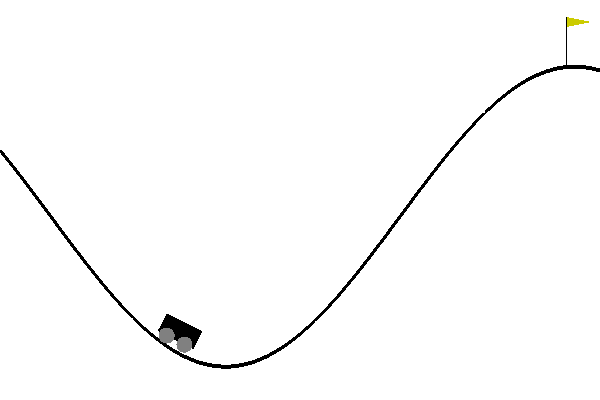

In [20]:
ds=ExperienceSourceDataset("MountainCar-v0",n_envs=15,skip_n_steps=1,pixels=True)
ds=DatasetDisplayWrapper(ds,1,1,800)
dl=DataLoader(ds,batch_size=1,num_workers=0)
for xb,yb in dl:pass

## ExperienceSourceDataBunch

In [21]:
# export
class ExperienceSourceDataBunch(DataBunch):
    @classmethod
    def from_env(cls,env:str,n_envs=1,firstlast=False,display=False,max_steps=None,skip_n_steps=1,path:PathOrStr='.',add_valid=True,
                 cols=1,rows=1,max_w=800,bs=1):
        def create_ds(make_empty=False):
            _ds_cls=FirstLastExperienceSourceDataset if firstlast else ExperienceSourceDataset
            _ds=_ds_cls(env,max_steps=0 if make_empty else max_steps,skip_n_steps=skip_n_steps)
            if display:_ds=DatasetDisplayWrapper(_ds,cols=cols,rows=rows,max_w=max_w)
            return _ds
            
        dss=(create_ds(),create_ds(not add_valid))
        return cls.create(*dss,bs=bs,num_workers=0)
    
    @classmethod
    def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
               val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
               device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, **dl_kwargs)->'DataBunch':
        "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        dls = [DataLoader(d, b, shuffle=s, drop_last=s, num_workers=num_workers, **dl_kwargs) for d,b,s in
               zip(datasets, (bs,val_bs,val_bs,val_bs), (False,False,False,False)) if d is not None]
        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [22]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=False,firstlast=False,add_valid=False,bs=5)
for xb,yb in data.train_dl:
    assert xb.shape[0]<=5

[08-21 01:56:59] p22390 line:69 WARNING - `self.learn` is None. will use random actions instead.


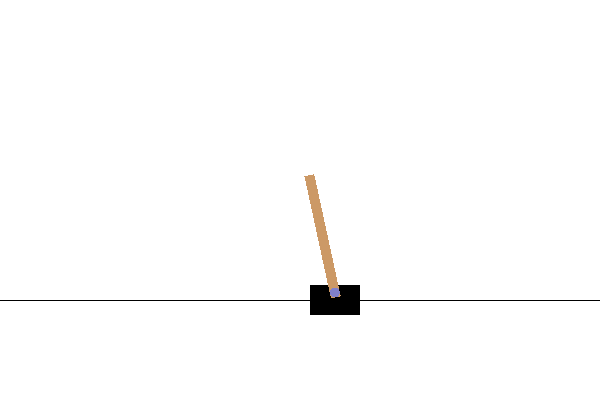

In [23]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=True,firstlast=True,add_valid=False,bs=5)
for xb,yb in data.train_dl:
    assert len(xb)<=5

# Async ExperienceSources

Async Experience sources have the challenge of running single process ExperienceSources in separate threads. Some questions are how rigid we want to make the actual fit look.

There are currently 2 ways to setup an Async dataset:
- Agent gets the data collected from the child processes. The model gets updated on the main thread which intern reflects in the child processes.
- A sub learner runs inside each process and fits up until the back prop. Instead of doing back prop in the process, we collect the gradients and update them in the main thread. 

The first one is farely straight forward and only requires the model, the agent, and an uninstantiated Dataset.
The second is more complex. We basically have 2 fit procedures shared between the main process and the child processes. 

In [24]:
# export            
def getattrsoftly(o:Optional[object],name:str,default):return getattr(o,name,default) if o is not None else default
def arginpartial(fn,arg_v):return arg_v in fn.args if fn.__class__==partial else False
def dequeuesoftly(q:mp.Queue,e:mp.Event,n_attempts=5,warnings=False):
    entry=None
    count=0
    while not e.is_set():
        try:
            entry=q.get_nowait()
            count=0
            break
        except Empty:
            if e.is_set():break
            e.wait(count/10)
            count+=1
            if count>n_attempts:
                _logger.warning('Breaking')
                break
            if warnings:_logger.warning('Queue was empty. At count: %s',count)
    return entry

In [29]:
# export
class AsyncException(Exception):pass

class AsyncExperienceSourceCallback(LearnerCallback):
    _order = -11
    def current_ds(self):
        return (self.learn.data.train_ds if self.learn.model.training or self.learn.data.empty_val else
                self.learn.data.valid_ds)
    
    def on_train_begin(self,**kwargs):
        for ds in [self.learn.data.train_ds,None if self.learn.data.empty_val else self.learn.data.valid_ds]:
            if ds is not None:
                ds.learn=self.learn
                ds.start_procs()
                
                
    def on_epoch_begin(self,**kwargs):
        if not self.learn.data.empty_val:self.current_ds().unpause()    
    def on_batch_end(self,**kwargs):
        if not self.learn.data.empty_val:self.current_ds().pause()
    def on_train_end(self,**kwargs):
        for ds in [self.learn.data.train_ds,None if self.learn.data.empty_val else self.learn.data.valid_ds]:
            if ds is not None:ds.end_procs()

def _fitter(model:Optional[nn.Module],learner_cls:Optional['AgentLearner'],agent:Optional['BaseAgent'],ds_cls:ExperienceSourceDataset,
            pause_event:mp.Event,cancel_event:mp.Event,main_queue:Optional[mp.JoinableQueue],metric_queue:Optional[mp.JoinableQueue]):
    "Default fitter for AsyncExperienceSourceDataset."
    ds=ds_cls()
    dl=DataLoader(ds,batch_size=1,num_workers=0)
    if learner_cls is not None:
        learn=learner_cls(data=DataBunch(dl,dl),model=model,agent=agent)
        ds.learn=learn
    try:
        while not cancel_event.is_set():
            for xb,yb in ds:
                while pause_event.is_set() and not self.cancel_event.is_set():cancel_event.wait(0.1)
                if main_queue is not None:main_queue.put(yb)
            if metric_queue is not None:
                total_rewards=ds.pop_total_rewards()
                if total_rewards:
                    if metric_queue.full():_logger.warning('Metric queue is full. Increase its size,empty it, or set metric_queue to None.')
                    metric_queue.put(TotalRewards(total_rewards))                    
            while pause_event.is_set():pass
    finally:
        main_queue.put(None)
        metric_queue.put(None)
        cancel_event.set()
        sys.stdout.flush()

@dataclass
class AsyncExperienceSourceDataset(Dataset):
    env:str
    ds_cls:ExperienceSourceDataset.__class__
    bs:Optional[int]=1
    learn:Optional[Learner]=None
    callback_fns:List[LearnerCallback]=field(default_factory=lambda:[AsyncExperienceSourceCallback])
    n_processes:int=1
    pause_event:mp.Event=mp.Event()
    cancel_event:mp.Event=mp.Event()   
    queue_sz:Optional[int]=None
    main_queue:Optional[mp.JoinableQueue]=None
    metric_queue:Optional[mp.JoinableQueue]=None
    _proc_list:List[mp.Process]=field(default_factory=list)
    fitter_fn:Optional[Callable]=None
    fitter_kwargs:Dict=None
    ds_kwargs:Dict=field(default_factory=dict)
    learner_kwargs:Dict=field(default_factory=dict)
    dequeue_warnings:bool=False
    dequeue_n_attempts:int=50
    
    def __post_init__(self):
        if not arginpartial(self.ds_cls,self.env):self.ds_cls=partial(self.ds_cls,self.env)
        
        self.fitter_fn=self.get_fitter_fn()
        self.queue_sz=ifnone(self.queue_sz,self.n_processes)
        self.main_queue=ifnone(self.main_queue,mp.JoinableQueue(self.queue_sz))
        if self.queue_sz!=0:self.dequeue_n_attempts//=self.queue_sz

    def __enter__(self):
        self.start_procs()
        return self
    
    def __len__(self):return self.bs
    
    def __exit__(self,*exc):
        self.end_procs()
        return False
    
    def get_fitter_fn(self):return getattrsoftly(self.learn,'fitter_fn',ifnone(self.fitter_fn,_fitter))
    def init_fitter_kwargs(self):
        ds_cls=partial(self.ds_cls,**self.ds_kwargs)
        fitter_kwargs=ifnone(self.fitter_kwargs,{'model':getattrsoftly(self.learn,'model',None),
                                                 'agent':getattrsoftly(self.learn,'agent',None),
                                                 'learner_cls':getattrsoftly(self.learn,'__class__',None),
                                                 'ds_cls':ds_cls})
        for k,v in zip(('pause_event','cancel_event','main_queue','metric_queue'),
                       (self.pause_event,self.cancel_event,self.main_queue,self.metric_queue)):
            fitter_kwargs[k]=fitter_kwargs.get(k,v)
        if fitter_kwargs['learner_cls'] is not None:
            fitter_kwargs['learner_cls']=partial(fitter_kwargs['learner_cls'],**self.learner_kwargs)
        return fitter_kwargs
        
    def start_procs(self):
        fitter_kwargs=self.init_fitter_kwargs()
        if self.learn is None:                   _logger.warning('`self.learn` is None. Async\'s ds_cls will likely use random actions.')
        elif not hasattr(self.learn,'fitter_fn'):_logger.warning('`self.learn` does not have a `fitter_fn`. Using default.')
        for e in (self.cancel_event,self.pause_event):e.clear()
        if len(self._proc_list)!=0:raise AsyncException('There are existing processes. Call: `end_procs`')
        self.populate_proc_list(self.get_fitter_fn(),fitter_kwargs)
        for o in self._proc_list:o.start()
            
    def populate_proc_list(self,fitter_fn,fitter_kwargs):
        self._proc_list=[mp.Process(target=fitter_fn,kwargs=fitter_kwargs) for _ in range(self.n_processes)]
        
    def end_procs(self):
        self.cancel_event.set()
        for q in [v for v in self.__dict__.values() if isinstance(mp.JoinableQueue,type(v))]:self.q_empty(q)
        for p in self._proc_list:
            p.join(timeout=0)
            p.terminate()
        self._proc_list.clear()
        
    def pause(self):self.pause_event.set()
    def unpause(self):self.pause_event.clear()
        
    def q_empty(self,q:mp.JoinableQueue):
        while not q.empty():q.get()
            
    def __iter__(self):
        while True:
            try:yield self.__getitem__(None)
            except StopIteration:return
            
    def __getitem__(self,_):
        if len(self._proc_list)==0:raise StopIteration()
        train_entry=dequeuesoftly(self.main_queue,self.cancel_event,self.dequeue_n_attempts,self.dequeue_warnings)
        if train_entry is None:raise StopIteration()
        return [Experience(**train_entry).x],train_entry

In [30]:
from fastrl.basic_train import AgentLearner
from fastcore.test import test_eq

bs=4

class FakeRunCallback(LearnerCallback):
    def on_backward_begin(self,*args,**kwargs): return {'skip_bwd':True,'skip_validate':True}
    def on_batch_begin(self,last_target,last_input,*args,**kwargs):
        test_eq(len(last_target['s']),bs)
        test_eq(last_input[0].shape[0],bs)

ds=AsyncExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=bs,n_processes=4,dequeue_warnings=False)
ds_empty=AsyncExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=0,n_processes=0,dequeue_warnings=False)
dl=DataLoader(ds,batch_size=bs,num_workers=0)
dl_empty=DataLoader(ds_empty,batch_size=bs,num_workers=0)
data=DataBunch(dl,dl_empty)

model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback])
learn.fit(10,lr=0.01,wd=1)

[08-21 02:05:56] p22390 line:106 WARNING - `self.learn` does not have a `fitter_fn`. Using default.


epoch,train_loss,valid_loss,time
0,0.500000,#na#,00:00
1,0.500000,#na#,00:00
2,0.500000,#na#,00:00
3,0.500000,#na#,00:00
4,0.500000,#na#,00:00
5,0.500000,#na#,00:00
6,0.500000,#na#,00:00
7,0.500000,#na#,00:00
8,0.500000,#na#,00:00
9,0.500000,#na#,00:00


In [32]:
bs=40
ds=AsyncExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=bs,n_processes=1,dequeue_warnings=False)
dl=DataLoader(ds,batch_size=bs,num_workers=0)

batch_shapes=[]
full_data=[]
with ds:
    for xb,yb in dl:
        batch_shapes.append(xb[0].shape)
        full_data.append(yb)
        if len(batch_shapes)-2>bs:raise AsyncException('batch_shapes should not be larger than the `ds.bs`*`ds.max_steps`')
        if batch_shapes[0][0]-2>bs:raise AsyncException('batch_shapes should not be larger than the `ds.bs`')

test_eq(batch_shapes[0][0],bs)
test_eq(full_data[0]['s'].shape[0],bs)
test_eq(batch_shapes[0],(bs,4))
test_eq(type(full_data[0]),dict)

[08-21 02:06:04] p22390 line:105 WARNING - `self.learn` is None. Async's ds_cls will likely use random actions.
[08-21 02:06:04] p22548 line:69 WARNING - `self.learn` is None. will use random actions instead.


In [33]:
from fastrl.basic_train import AgentLearner
from fastcore.test import test_eq
bs=90

class AlwaysDiscreteRight(nn.Module):
    def __init__(self,*args,**kwargs):
        super(AlwaysDiscreteRight,self).__init__(*args,**kwargs)
        self.a=1
        
    def forward(self,x):
        return FloatTensor([[0.1,0.5]])
    
class AlwaysDiscreteLeft(nn.Module):
    def __init__(self,*args,**kwargs):
        super(AlwaysDiscreteLeft,self).__init__(*args,**kwargs)
        self.a=0
    
    def forward(self,x):
        return FloatTensor([[0.5,0.1]])
    
for m in (AlwaysDiscreteRight(),AlwaysDiscreteLeft()):
    print(f'Testing action: {m.a}')
    ds=AsyncExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=bs,n_processes=4,dequeue_warnings=False)
    dl=DataLoader(ds,batch_size=bs,num_workers=12)

    model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2),m)
    agent=DQNAgent(model=model)
    learn=AgentLearner(DataBunch(dl,dl),model,agent=agent)
    ds.learn=learn

    batch_shapes=[]
    full_data=[]
    with ds:
        for xb,yb in dl:
            batch_shapes.append(xb[0].shape)
            full_data.append(copy(yb))
            if len(batch_shapes)>bs:raise AsyncException('batch_shapes should not be larger than the `ds.bs`*`ds.max_steps`')
            if batch_shapes[0][0]>bs:raise AsyncException('batch_shapes should not be larger than the `ds.bs`')
    assert all(any(o['d']) for o in full_data if len(o['d'])==bs),'Dones are not being returned'
    assert all(all([a==m.a for a in o['a']]) for o in full_data)
    test_eq(sum(len(o['s']) for o in full_data),bs)
    full_data.clear()
    batch_shapes.clear()

[08-21 02:06:08] p22390 line:106 WARNING - `self.learn` does not have a `fitter_fn`. Using default.


Testing action: 1


[08-21 02:06:10] p22390 line:106 WARNING - `self.learn` does not have a `fitter_fn`. Using default.


Testing action: 0


In [ ]:
# export
add_docs(AsyncExperienceSourceDataset,
        __init__='Asynchronous form of ExperienceSourceDataset. Requires using `with AsyncExperienceSourceDataset():` or calling `start_procs()`'
        ' before looping and `end_procs()` after looking. Using the context manager would be better due to exception handling so we can avoid any'
        ' hanging processes. Returns the data samples from all processes, however can be modfied to behave differently.',
        start_procs='Start the background processes for the environments. Also called in the context manager `__enter__` method.',
        end_procs='End the processes cleanly. Also called in the context manager `__exit__` method.',
        pause='Will cause the environments to stop iterating through episodes. Used for switching between test and train datasets.',
        unpause='Allows environments to continue iterating.',
        populate_proc_list='Initializes the process list `_proc_list`.',
        q_empty='Goes through all `mp.JoinableQueue` queues and empties them. This is typically done during `end_procs`',
        init_fitter_kwargs='Key work args to pass to the `fitter_fn`.',
        get_fitter_fn='Returns a `fitter_fn` defined in `self.learn` else try the default field.'
        )

In [ ]:
# export 
def _grad_fitter(model:Optional[nn.Module],learner_cls:Optional['AgentLearner'],agent:Optional['BaseAgent'],ds_cls:ExperienceSourceDataset,
            pause_event:mp.Event,cancel_event:mp.Event,main_queue:Optional[mp.JoinableQueue],metric_queue:Optional[mp.JoinableQueue]):
    "Default fitter for AsyncGradExperienceSourceDataset."
    ds=ds_cls()
    dl=DataLoader(ds,batch_size=1,num_workers=0)

    if learner_cls is not None:
        learn=learner_cls(data=DataBunch(dl,dl),model=model,agent=agent)
        ds.learn=learn
    try:
        while not cancel_event.is_set():
            for xb,yb in ds:
                while pause_event.is_set() and not self.cancel_event.is_set():cancel_event.wait(0.1)
                if main_queue is not None:
                    loss=0.5 # Place holder
                    main_queue.put((xb,{'loss':loss,**yb}))
            if metric_queue is not None:
                total_rewards=ds.pop_total_rewards()
                if total_rewards:
                    if metric_queue.full():_logger.warning('Metric queue is full. Increase its size,empty it, or set metric_queue to None.')
                    metric_queue.put(TotalRewards(total_rewards))                    
            while pause_event.is_set():pass
    finally:
        main_queue.put(None)
        metric_queue.put(None)
        cancel_event.set()
        sys.stdout.flush()

class AsyncGradExperienceSourceDataset(AsyncExperienceSourceDataset): 
    def __post_init__(self):
        self.fitter_fn=ifnone(self.fitter_fn,_grad_fitter)
        super(AsyncGradExperienceSourceDataset,self).__post_init__()
        
    def __getitem__(self,_):
        if len(self._proc_list)==0:raise StopIteration()
        gradients,loss=dequeuesoftly(self.main_queue,self.cancel_event,self.dequeue_n_attempts,self.dequeue_warnings)
        if gradients is None:raise StopIteration()
        return [gradients],[loss]

In [ ]:
class FakeRunCallback(LearnerCallback):
    def on_backward_begin(self,*args,**kwargs): return {'skip_bwd':True,'skip_validate':True}
    
bs=40

ds=AsyncGradExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=bs,n_processes=4,dequeue_warnings=False)
ds_empty=AsyncGradExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=0,n_processes=0,dequeue_warnings=False)
dl=DataLoader(ds,batch_size=bs,num_workers=0)
dl_empty=DataLoader(ds_empty,batch_size=bs,num_workers=0)
data=DataBunch(dl,dl_empty)

model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback])
learn.fit(3,lr=0.01,wd=1)

In [ ]:
bs=40
ds=AsyncGradExperienceSourceDataset('CartPole-v1',ExperienceSourceDataset,bs=bs,n_processes=1,dequeue_warnings=False)
dl=DataLoader(ds,batch_size=bs,num_workers=12)

batch_shapes=[]
full_data=[]
with ds:
    for xb,yb in dl:
        batch_shapes.append(xb[0].shape)
        full_data.append(yb)
        if len(batch_shapes)-2>bs:raise AsyncException('batch_shapes should not be larger than the `ds.bs`*`ds.max_steps`')
        if batch_shapes[0][0]-2>bs:raise AsyncException('batch_shapes should not be larger than the `ds.bs`')

test_eq(batch_shapes[0][0],bs)
test_eq(full_data[0][0]['loss'].shape[0],bs)
test_eq(batch_shapes[0],(bs,4))
test_eq(type(full_data[0]),list)

In [ ]:
# export
add_docs(AsyncGradExperienceSourceDataset,
         textwrap.fill("""The `AsyncGradExperienceSourceDataset` class is instantiated via passing 
         the `env_name` that we want to train on, and a `partial` class of a `ExperienceSourceDataset` called `ds_cls`.
         `bs` is a field here since the length of the dataset is not necessarily the length of an episode. If `None` it will be the length
         of a single episode of the environment. Agents such as A3C will likely change this."""))

In [ ]:
# export
class AsyncExperienceSourceDataBunch(ExperienceSourceDataBunch):
    @classmethod
    def from_env(cls,env,bs=16,use_grad_experience=False,firstlast=False,n_processes=defaults.cpus,num_workers:int=defaults.cpus,queue_sz=None,add_valid=False,
                fitter_fn=None,ds_kwargs:Dict=None,fitter_kwargs:Dict=None,learner_kwargs:Dict=None):
        def create_ds(make_empty=False):
            _sub_ds_cls=FirstLastExperienceSourceDataset if firstlast else ExperienceSourceDataset
            _ds_cls=AsyncGradExperienceSourceDataset if use_grad_experience else AsyncExperienceSourceDataset
            _ds=_ds_cls(env,bs=0 if make_empty else bs,ds_cls=_sub_ds_cls,n_processes=n_processes,queue_sz=queue_sz,fitter_fn=fitter_fn,
                        ds_kwargs=ifnone(ds_kwargs,{}),fitter_kwargs=fitter_kwargs,learner_kwargs=ifnone(learner_kwargs,{}))
            return _ds
            
        return cls.create(create_ds(),create_ds(not add_valid),bs=bs,num_workers=0)

In [ ]:
bs=16
data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1',bs=bs)

batch_shapes=[]
full_data=[]
with data.train_ds:
    for xb,yb in data.train_dl:
        batch_shapes.append(xb[0].shape)
        full_data.append(yb)
        if len(batch_shapes)>bs:raise AsyncException('batch_shapes should not be larger than `bs`')
        if batch_shapes[0][0]>bs:raise AsyncException('batch_shapes should not be larger than `bs`')

In [ ]:
data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1')
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback]).fit(3,lr=0.01,wd=1)

In [ ]:
data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1',use_grad_experience=True)
AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback]).fit(3,lr=0.01,wd=1)

In [ ]:
data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1',use_grad_experience=True,ds_kwargs={'skip_n_steps':4})
AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback]).fit(3,lr=0.01,wd=1)

In [ ]:
# hide
from nbdev.export import *
notebook2script()
notebook2html(n_workers=0)